In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

Matplotlib is building the font cache; this may take a moment.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
ways = np.array([0,3,8,9,0])
ways / np.sum(ways)

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

# 2.1 Building a Model

"(1) Data story: Motivate the model by narrating how the data might arise.
(2) Update: Educate your model by feeding it the data.
(3) Evaluate: All statistical models require supervision, leading to model revision." (p. 29)

In [4]:
stats.binom.pmf(k = 6, n = 9, p = 0.5)

0.16406250000000003

### 2.4 Motors

#### 2.4.3 Grid Approximation

(1) Define the grid. This means you decide how many points to use in estimating the
posterior, and then you make a list of the parameter values on the grid.

(2) Compute the value of the prior at each parameter value on the grid.

(3) Compute the likelihood at each parameter value.

(4) Compute the unstandardized posterior at each parameter value, by multiplying the
prior by the likelihood.

(5) Finally, standardize the posterior, by dividing each value by the sum of all values.

In [5]:
def get_graph_approximation_posterior(p_grid, prior, W, L) -> np.array:
    # (1) Define grid
    p_grid = p_grid

    # (2) Define prior
    prior = prior

    # (3) Compute the likelihood at each value in the grid
    likelihood = stats.binom.pmf(L, W, p_grid)

    # (4) Compute the unstandardized posterior
    unstd_posterior = likelihood * prior

    # (5) Standardize the posterior
    posterior = unstd_posterior / np.sum(unstd_posterior)

    return posterior

In [6]:
# Define our graph approximator
def plot_graph_approximation(p_grid, posterior, xlabel, ylabel, title) -> plt:
    plt.plot(p_grid, posterior, marker='o', linestyle='-', color='blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    return plt.show()

In [7]:
# Define our initial p_grid and prior
p_grid = np.linspace(0, 1, 20)
prior = np.ones(20)

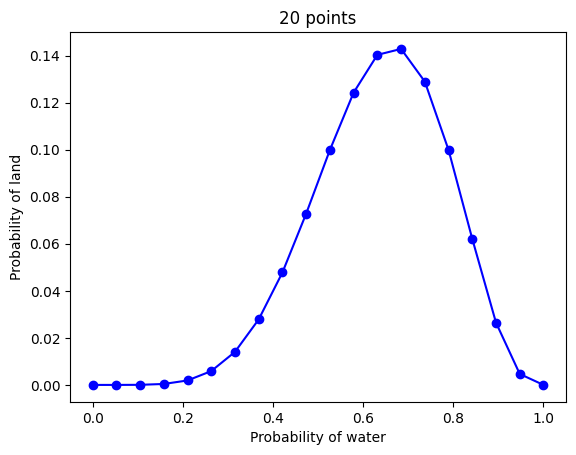

In [8]:
# Plot the posterior distribution
posterior = get_graph_approximation_posterior(p_grid, prior, W=9, L=6)
plot_graph_approximation(
    p_grid,
    posterior,
    xlabel="Probability of water",
    ylabel="Probability of land",
    title=f"{len(p_grid)} points",
)

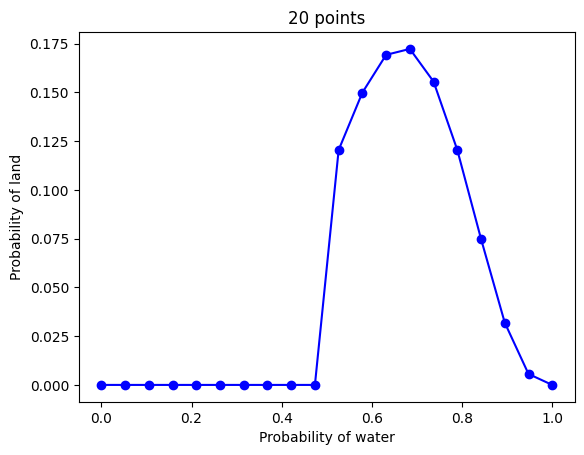

In [9]:
# Try with different priors
prior = np.where(p_grid < 0.5, 0, 1)
posterior = get_graph_approximation_posterior(p_grid, prior, W=9, L=6)

plot_graph_approximation(
    p_grid,
    posterior,
    xlabel="Probability of water",
    ylabel="Probability of land",
    title=f"{len(p_grid)} points",
)

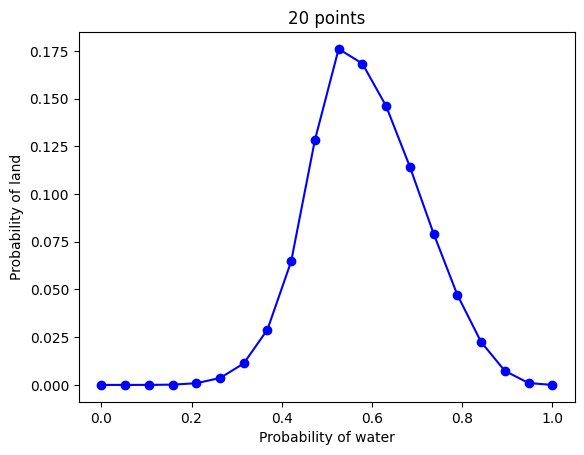

In [10]:
prior = np.exp(-5 * np.abs(p_grid - 0.5))
posterior = get_graph_approximation_posterior(p_grid, prior, W=9, L=6)
plot_graph_approximation(
    p_grid,
    posterior,
    xlabel="Probability of water",
    ylabel="Probability of land",
    title=f"{len(p_grid)} points",
)

#### 2.4.4 Quadtratic Approximation

In [11]:
# Define data
W = 36
L = 24

# Define the model
with pm.Model() as model:
    # Prior
    p = pm.Uniform("p", lower=0, upper=1)

    # Likelihood
    W_obs = pm.Binomial("W_obs", n=W+L, p=p, observed=W)

    # Find MAP estimate
    map_estimate = pm.find_MAP()
    
    # Calculate Hessian at MAP estimate
    hessian = pm.find_hessian(map_estimate, vars=[p], negate_output=False)
    stddev = np.sqrt(np.diag(hessian)) # Standard deviation from hessian

    # Approximate posterior mean and standard deviation
    summary = {
        'p_mean': map_estimate['p'],
        'p_std': stddev[0]
    }
    print(summary)

Output()

{'p_mean': array(0.6), 'p_std': nan}


/var/folders/d5/kprqgbfx20x6hb3x61dh8b6w0000gp/T/ipykernel_76926/4115912159.py:18: RuntimeWarning: invalid value encountered in sqrt
  stddev = np.sqrt(np.diag(hessian)) # Standard deviation from hessian


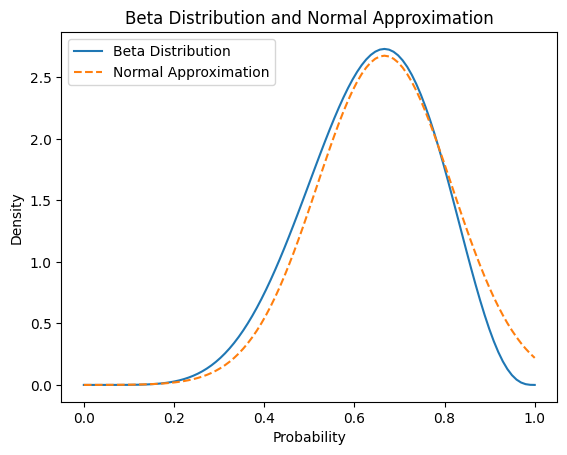

In [12]:
# Analytical calculation
W = 6
L = 3

# Beta distribution
x = np.linspace(0, 1, 100)
beta_pdf = stats.beta.pdf(x, W+1, L+1)

# Normal approximation
mean = W / (W+L)
std_dev = np.sqrt(mean*(1-mean)/(W+L+1))
norm_pdf = stats.norm.pdf(x, mean, std_dev)

# Plot & visualize
plt.plot(x, beta_pdf, label='Beta Distribution')
plt.plot(x, norm_pdf, label='Normal Approximation', linestyle='--')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Beta Distribution and Normal Approximation')
plt.show()


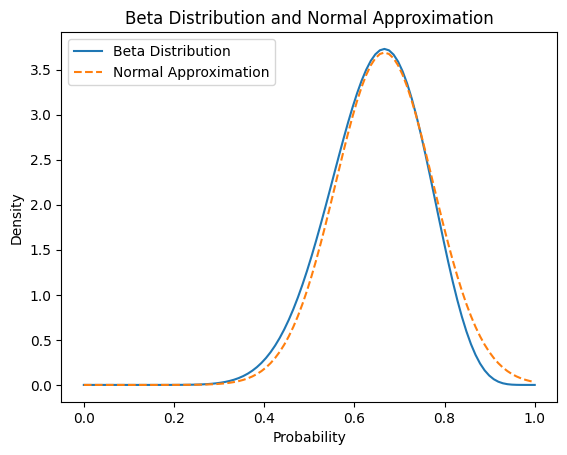

In [13]:
# Double the observations, and see how the approximation improves
# Analytical calculation
W = 12
L = 6

# Beta distribution
x = np.linspace(0, 1, 100)
beta_pdf = stats.beta.pdf(x, W+1, L+1)

# Normal approximation
mean = W / (W+L)
std_dev = np.sqrt(mean*(1-mean)/(W+L+1))
norm_pdf = stats.norm.pdf(x, mean, std_dev)

# Plot & visualize
plt.plot(x, beta_pdf, label='Beta Distribution')
plt.plot(x, norm_pdf, label='Normal Approximation', linestyle='--')
plt.legend()
plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Beta Distribution and Normal Approximation')
plt.show()


#### 2.4.5 Markov chain Monte Carlo

In [14]:
# Quick example using the Metropolis-Hastings algorithm
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3

for i in range(1, n_samples):
    p_new = np.random.normal(p[i-1], 0.1)
    p_new = max(0, min(p_new, 1)) # Ensure p_new between 0 and 1

    q0 = np.exp(np.log(p[i-1]) * W + np.log(1-p[i-1]) * L)
    q1 = np.exp(np.log(p_new) * W + np.log(1-p_new) * L)

    acceptance_ratio = min(1, q1 / q0)
    if np.random.uniform() < acceptance_ratio:
        p[i] = p_new
    else:
        p[i] = p[i-1]

/var/folders/d5/kprqgbfx20x6hb3x61dh8b6w0000gp/T/ipykernel_76926/3640828001.py:13: RuntimeWarning: divide by zero encountered in log
  q1 = np.exp(np.log(p_new) * W + np.log(1-p_new) * L)


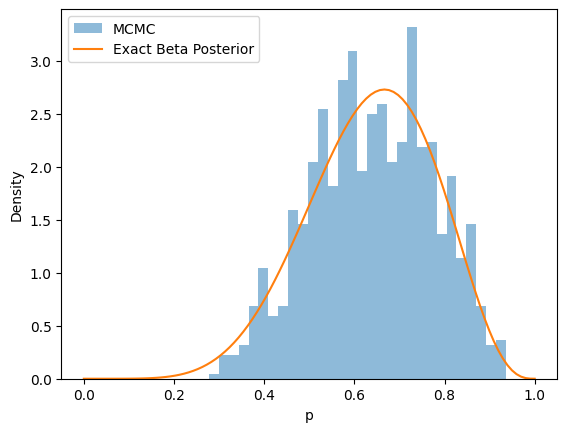

In [15]:
# Plot the histogram
plt.hist(p, bins=30, density=True, alpha=0.5, label='MCMC')

# Plot the exact Beta posterior
x = np.linspace(0, 1, 100)
beta_pdf = stats.beta.pdf(x, W+1, L+1)
plt.plot(x, beta_pdf, label='Exact Beta Posterior')

plt.xlabel('p')
plt.ylabel('Density')
plt.legend()
plt.show()

### 2.6 Practice

In [16]:
# 2M1
def compute_and_plot_graph_approximation(
    prior, p_grid, W, L, xlabel, ylabel, title
) -> plt.plot:
    posterior = get_graph_approximation_posterior(p_grid, prior, W, L)
    return plot_graph_approximation(p_grid, posterior, xlabel, ylabel, title)

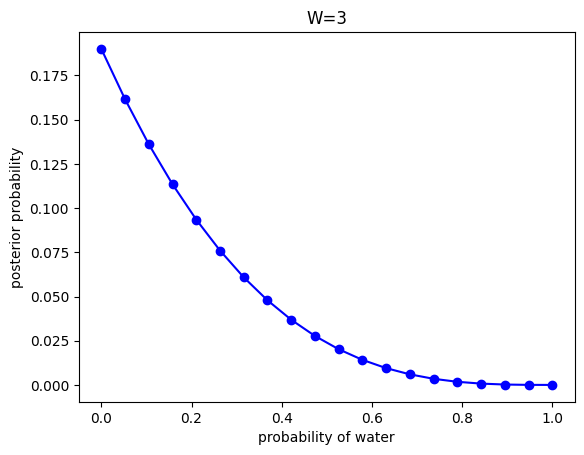

In [17]:
## (1)
compute_and_plot_graph_approximation(
    prior=np.ones(20),
    p_grid=np.linspace(0, 1, 20),
    W=3,
    L=0,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="W=3"
)

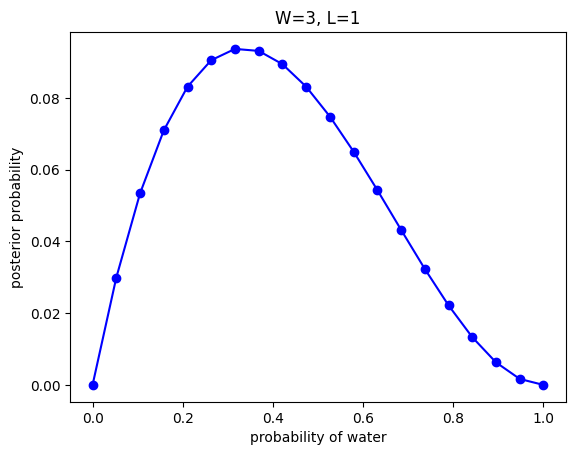

In [18]:
## (2)
compute_and_plot_graph_approximation(
    prior=np.ones(20),
    p_grid=np.linspace(0, 1, 20),
    W=3,
    L=1,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="W=3, L=1"
)

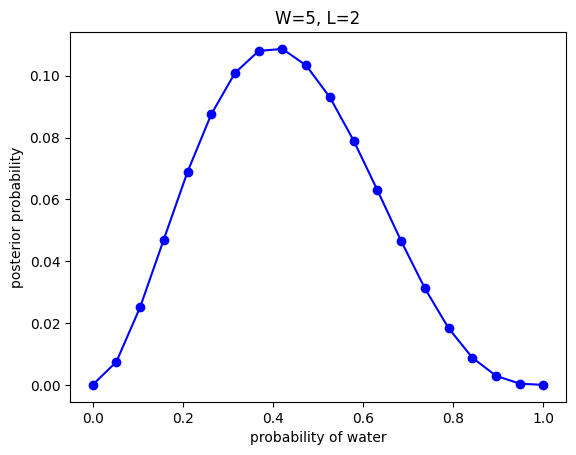

In [19]:
## (3)
compute_and_plot_graph_approximation(
    prior=np.ones(20),
    p_grid=np.linspace(0, 1, 20),
    W=5,
    L=2,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="W=5, L=2"
)

In [20]:
# 2M2
p_grid = np.linspace(0, 1, 20)
prior = np.exp(-5 * np.abs(p_grid - 0.5))
prior[prior < 0.5] = 0 # Use numpy vectorized comparison

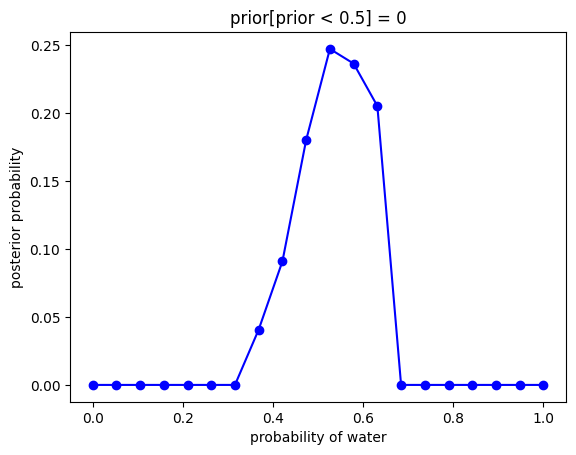

In [21]:
compute_and_plot_graph_approximation(
    prior = prior,
    p_grid = p_grid, 
    W=9,
    L=6,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="prior[prior < 0.5] = 0"
)

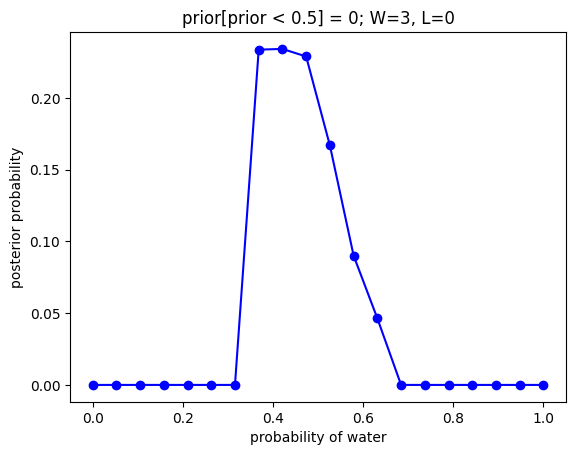

In [23]:
compute_and_plot_graph_approximation(
    prior = prior,
    p_grid = p_grid, 
    W=3,
    L=0,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="prior[prior < 0.5] = 0; W=3, L=0"
)

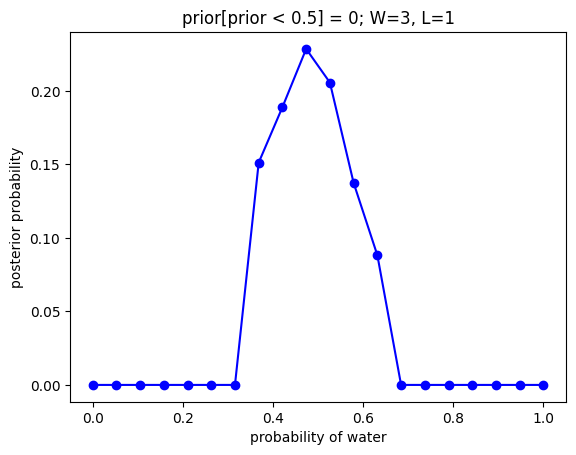

In [24]:
compute_and_plot_graph_approximation(
    prior = prior,
    p_grid = p_grid, 
    W=3,
    L=1,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="prior[prior < 0.5] = 0; W=3, L=1"
)

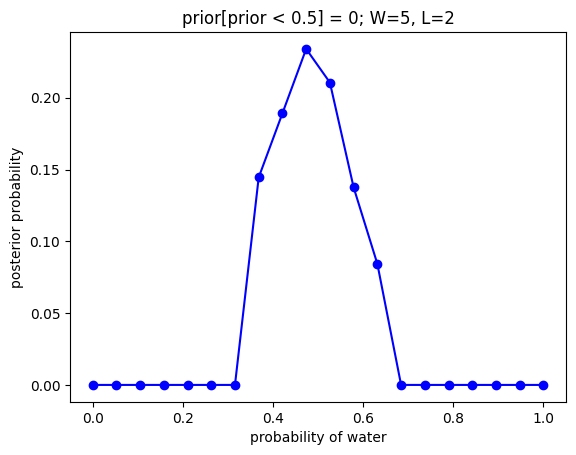

In [ ]:
compute_and_plot_graph_approximation(
    prior = prior,
    p_grid = p_grid, 
    W=5,
    L=2,
    xlabel="probability of water",
    ylabel="posterior probability",
    title="prior[prior < 0.5] = 0; W=5, L=2"
)

In [33]:
# 2M3
prob_Earth = .5
prob_Mars = .5

prob_Land_given_Mars = 1
prob_Land_given_Earth = .3

prob_Land = (prob_Land_given_Earth + prob_Land_given_Mars) / 2

prob_Earth_given_Land = (prob_Land_given_Earth * prob_Earth) / prob_Land
print(prob_Earth_given_Land)


0.23076923076923075


In [38]:
# 2M6
B = .5
W = 1
Cards = {
    'C1': [B,B],
    'C2': [B,W],
    'C3': [W,W],
}


#### 2H1
Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise birthing singleton infants. Assume these numbers are known with certainty, from many years of field research. Now suppose you are managing a captive panda breeding program. You have a new female panda of unknown species, and she has just given birth to twins. What is the probability that her next birth will also be twins? 

P(bear_a) = .5
P(bear_b) = .5

P(twins|bear_a) = .1
P(twins|bear_b) = .2

P(twins) = (.1+.2) / 2

In [45]:
# P(twins)
P_twins = round((.1+.2) / 2, 3)
P_twins

0.15

In [48]:
# 2H2
# P(bear_a|twins) = P(twins|bear_a) * P(bear_a) / P(twins)
P_bear_a_given_twins = round((.1 * .5) / .15, 3)
print(P_bear_a_given_twins)

0.333
